In [15]:
import numpy as np
from nn import *

In [16]:
from ucimlrepo import fetch_ucirepo
import pickle
import os

# Check if data exists, download if required
# save to disk after download to speed up on between runs

if os.path.exists("./data.pkl"):
    with open("./data.pkl", 'rb') as fp:
        rt_iot2022 = pickle.load(fp)
else:
    rt_iot2022 = fetch_ucirepo(id=942)
    with open("./data.pkl", 'wb') as fp:
        pickle.dump(rt_iot2022, fp)

In [17]:
# Remove axes that don't contribute to data, and get labels
features = rt_iot2022.data.features
targets = rt_iot2022.data.targets

unique = features.nunique(axis=0)
for i in range(len(unique)):
    if unique[i] <= 1:
        print("Removing", features.axes[1][i])
        del features[features.axes[1][i]]
# bwd_URG_flag count is always the same, usually removed

# Get labels for data (attack or normal behavior)
normal_patterns = ["MQTT_Publish", "Thing_Speak", "Wipro_bulb", "Amazon-Alexa"]
y_bool = [int(x in normal_patterns) for x in targets.values]

/tmp/ipykernel_1444248/875652746.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if unique[i] <= 1:


Removing bwd_URG_flag_count


In [18]:
# convert string to numerical
unique_service = list(features["service"].unique())
unique_proto = list(features["proto"].unique())
for i in range(len(features["service"])):
    features.loc[i, "service"] = unique_service.index(features["service"][i])
    features.loc[i, "proto"] = unique_proto.index(features["proto"][i])

In [19]:
# use only continous vars
continuous_vars = rt_iot2022.variables[rt_iot2022.variables['type'] == "Continuous"]['name'].tolist()
features = features[continuous_vars]

In [20]:
# fit all data from -1 to 1
def normalize_axis(axis):
    return (axis - axis.min()) / (axis.max() - axis.min())

X = features.values
X = X.T
for idx in range(len(X)):
    X[idx] = normalize_axis(X[idx]) 
X = X.T
X = X.astype('float64')

X.shape

(123117, 82)

In [21]:
# Split data into train/test sets
y = np.array(y_bool)
np.random.seed(2)

test_split = .2
test_samples = int(len(X) * test_split)
perm  = np.random.permutation(len(X))
X = X[perm]
y = y[perm]

x_train = X[test_samples:]
y_train = y[test_samples:]
x_test  = X[0:test_samples]
y_test  = y[0:test_samples]

In [22]:
x_train.shape

(98494, 82)

In [23]:
x_train = x_train.reshape((x_train.shape[0], 1, -1))
x_test = x_test.reshape((x_test.shape[0],1,-1))

In [24]:
model = Network()
model.add(FullyConnected(x_train.shape[2], 100))
model.add(Activation(tanh, tanh_prime))
model.add(FullyConnected(100, 50))
model.add(Activation(tanh, tanh_prime))
model.add(FullyConnected(50, 1))
model.add(Activation(tanh, tanh_prime))

model.use_loss(mse, mse_prime)

In [25]:
model.fit(x_train, y_train, 20, .01)
# model.fit(x_train, y_train, 40, .01)

epoch 0/20      error=0.023765765868845008
epoch 1/20      error=0.016812265051593
epoch 2/20      error=0.014183135175859105
epoch 3/20      error=0.012234938300384439
epoch 4/20      error=0.010774102849435826
epoch 5/20      error=0.009706414730585365
epoch 6/20      error=0.008930301865981531
epoch 7/20      error=0.008344039960746655
epoch 8/20      error=0.007887478072843134
epoch 9/20      error=0.007523689754018585
epoch 10/20      error=0.00722578528138014
epoch 11/20      error=0.006973421410412812
epoch 12/20      error=0.0067537244870126386
epoch 13/20      error=0.006559506545750554
epoch 14/20      error=0.006386086067575183
epoch 15/20      error=0.006229859192682062
epoch 16/20      error=0.006088273654625088
epoch 17/20      error=0.005958483133461246
epoch 18/20      error=0.005839497571037907
epoch 19/20      error=0.005728545026573951


In [26]:
import time

start = time.time()

predicted_class = np.array(model.predict(x_test))
predicted = predicted_class > .5
predicted = np.ravel(predicted)

print(f"Took {time.time() - start}")

true_positive = 0
true_negative = 0
false_positive = 0
false_negative = 0
for i in range(len(predicted)):
    if predicted[i] == 1:
        if predicted[i] == y_test[i]:
            true_positive += 1
        else:
            false_positive += 1
    elif predicted[i] == 0:
        if predicted[i] == y_test[i]:
            true_negative += 1
        else:
            false_negative += 1

pos_acc = true_positive / (true_positive + false_positive)
neg_acc = true_negative / (true_negative + false_negative)

print(f"pos_acc: {pos_acc}, neg_acc: {neg_acc}")

print("NN raw accuracy is:", (true_positive + true_negative)/len(predicted))
print("Balanced Acc is: ", (pos_acc+neg_acc)/2)

# TODO: why is this so high, leaking train data? or including id/label?

Took 0.1896960735321045
pos_acc: 0.9870077141697118, neg_acc: 0.9977436823104693
NN raw accuracy is: 0.9966697802867238
Balanced Acc is:  0.9923756982400905


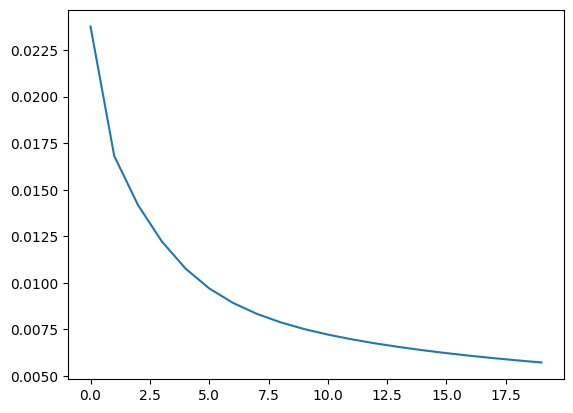

In [27]:
import matplotlib.pyplot as plt

plt.plot(model.losses)

In [28]:
with open("nn-all-loss.pkl", 'wb') as fp:
    pickle.dump(model.losses, fp)